In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import biogeme.vns as vns

# The multi-objective knapsack problem

In order to illustrate the use of the the multi-objective VNS algorithm, we consider a multi-objective version of the knapsack problem.  

A hiker prepares a hike in the mountain, and considers various items to put in her knapsack. Each item is associated with a utility, and with a weight. The hiker has two objectives: to maximize the total utility
and to minimize the total weight. In any case, the total weight cannot go beyond capacity.

In order to describe this problem, we need to implement two abstract classes from the ``vns`` module: ``vns.solutionClass`` and ``vns.problemClass``.

## Implementation of ``vns.solutionClass``

The ``vns.solutionClass`` object must implement the following methods, that are purely abstract in the ``vns``module: 

- ``__repr__(self)``: it must return a string (``str``) that characterized uniquely a given sack. This string is used by the algorithm to store and compare the solutions generated by the algorithm.
- ``__str__(self)``: it must return a string (``str``) that is used for reporting. 

It should also implement operators. An operator is a function that applies simple modification on a solution to obtain a "neighbor" solution. The syntax is: 

``def myOperator(aSolution, size=1):``

where ``aSolution`` is the solution to be modified, and ``size``is the number of elemental modifications to perform.

In our example, we implement the following operators: 

- ``def addItems(aSolution, size)``: adds up to ``size`` items in the sack,
- ``def removeItems(aSolution, size)``: removes up to ``size`` items in the sack,
- ``def changeDecisions(aSolution, size)``: changes the decision for up to ``size``items in the sack. Changing the decision means that we remove the item if it is in, and we add it if it is out. 

If N is the total number of items, a sack is characterized by a vector of length N, where each entry is either 1 (if the corresponding item is in the sack) or 0 (if the corresponding item is not in the sack). 

The attribute ``objectivesNames`` and ``objectives`` capture the objective functions that must be minimized. In our case, as we want to maximize the utility, we define the negative unitility as one of the objectives: 

``objectivesNames = ['Weight', 'Negative utility']``


In [2]:
class oneSack(vns.solutionClass):
    """Implements the virtual class. A solution here is a sack
    configuration.

    """
    def __init__(self, solution):
        super().__init__()
        self.x = solution
        self.objectivesNames = ['Weight', 'Negative utility']
        self.objectives = None

    def isDefined(self):
        """Check if the sack is well defined.

        :return: True if the configuration vector ``x`` is defined,
            and the total weight and total utility are both defined.
        :rtype: bool
        """
        if self.x is None:
            return False
        if self.objectives is None:
            return False
        return True

    def __repr__(self):
        return str(self.x)

    def __str__(self):
        return str(self.x)

def addItems(aSolution, size=1):
    """Add ``size`` items in the sack

    :param aSolution: current sack
    :type aSolution: class oneSack

    :param size: number of items to add into the sack
    :type size: int

    :return: new sack, and number of changes actually made
    :rtype: tuple(class oneSack, int)
    """
    absent = np.where(aSolution.x == 0)[0]
    np.random.shuffle(absent)
    n = min(len(absent), size)
    xplus = aSolution.x.copy()
    xplus[absent[:n]] = 1
    return oneSack(xplus), n

def removeItems(aSolution, size=1):
    """Remove ``size`` items from the sack

    :param aSolution: current sack
    :type aSolution: class oneSack

    :param size: number of items to remove from the sack
    :type size: int

    :return: new sack, and number of changes actually made
    :rtype: tuple(class oneSack, int)
    """
    present = np.where(aSolution.x == 1)[0]
    np.random.shuffle(present)
    n = min(len(present), size)
    xplus = aSolution.x.copy()
    xplus[present[:n]] = 0
    return oneSack(xplus), n

def changeDecisions(aSolution, size=1):
    """Change the status of ``size`` items in the sack.

    :param aSolution: current sack
    :type aSolution: class oneSack

    :param size: number of items to modify
    :type size: int

    :return: new sack, and number of changes actually made
    :rtype: tuple(class oneSack, int)

    """
    n = len(aSolution.x)
    order = np.random.permutation(n)
    xplus = aSolution.x.copy()
    for i in range(min(n, size)):
        xplus[order[i]] = 1 - xplus[order[i]]
    return oneSack(xplus), n



## Implementation of ``vns.problemClass``

The ``vns.problemClass`` object must implement the following methods, that are purely abstract in the ``vns``module: 

- ``isValid(self, aSolution)``
- ``evaluate(self, aSolution)``
- ``describe(self, aSolution)``
- ``generateNeighbor(self, aSolution, neighborhoodSize)``
- ``neighborRejected(self, aSolution, aNeighbor)``
- ``neighborAccepted(self, aSolution, aNeighbor)``

Note that, in our implementation, we rely on the ``operatorsManagement``class of the ``vns`` module to generate the neighbors. But this is not mandatory.

In [3]:
class knapsack(vns.problemClass):
    """Class defining the knapsack problem. Note the inheritance from the
    abstract class used by the VNS algorithm. It guarantees the
    compliance with the requirements of the algorithm.

    """

    def __init__(self, aUtility, aWeight, aCapacity):
        """Ctor"""
        super().__init__()
        self.utility = aUtility
        self.weight = aWeight
        self.capacity = aCapacity
        self.operators = {
            'Add items': addItems,
            'Remove items': removeItems,
            'Change decision for items': changeDecisions,
        }
        self.operatorsManagement = vns.operatorsManagement(
            self.operators.keys()
        )
        self.currentSolution = None
        self.lastOperator = None

    def emptySack(self):
        """
        :return: empty sack of the same dimension.
        :rtype: class oneSack
        """
        z = np.zeros_like(self.utility)
        theSack = oneSack(z)
        return oneSack(z)

    def isValid(self, aSolution):
        """Check if the sack verifies the capacity constraint

        :param aSolution: sack to check
        :type aSolution: class oneSack

        :return: True if the capacity constraint is verified
        :rtype: bool
        """
        self.evaluate(aSolution)
        return aSolution.objectives[0] <= self.capacity, 'Infeasible sack'

    def evaluate(self, aSolution):
        """ Calculates the total weight and the total utility of a sack.

        :param aSolution: sack to evaluate
        :type aSolution: class oneSack

        """
        aSolution.objectives = [
            np.inner(aSolution.x, self.weight),
            -np.inner(aSolution.x, self.utility)
        ]

    def describe(self, aSolution):
        """Short description of a sack

        :param aSolution: sack to describe
        :type aSolution: class oneSack

        :return: description
        :rtype: str
        """
        return str(aSolution)

    def generateNeighbor(self, aSolution, neighborhoodSize):
        """Generate a neighbor from the negihborhood of size
        ``neighborhoodSize``using one of the operators

        :param aSolution: current solution
        :type aSolution: class oneSack

        :param neighborhoodSize: size of the neighborhood
        :type neighborhoodSize: int

        :return: number of modifications actually made
        :rtype: int

        """
        # Select one operator.
        self.lastOperator = self.operatorsManagement.selectOperator()
        return self.applyOperator(
            aSolution, self.lastOperator, neighborhoodSize
        )

    def neighborRejected(self, aSolution, aNeighbor):
        """Informs the operator management object that the neighbor has been
        rejected.

        :param aSolution: current solution
        :type aSolution: class oneSack

        :param aNeighbor: proposed neighbor
        :type aNeighbor: class oneSack

        :raise biogemeError: if no operator has been used yet.
        """
        if self.lastOperator is None:
            raise excep.biogemeError('No operator has been used yet.')
        self.operatorsManagement.decreaseScore(self.lastOperator)

    def neighborAccepted(self, aSolution, aNeighbor):
        """Informs the operator management object that the neighbor has been
        accepted.

        :param aSolution: current solution
        :type aSolution: class oneSack

        :param aNeighbor: proposed neighbor
        :type aNeighbor: class oneSack

        :raise biogemeError: if no operator has been used yet.
        """
        if self.lastOperator is None:
            raise excep.biogemeError('No operator has been used yet.')
        self.operatorsManagement.increaseScore(self.lastOperator)

    def applyOperator(self, solution, name, size=1):
        """Apply a specific operator on a solution, using a neighborhood of
        size ``size``

        :param solution: current solution
        :type solution: class oneSack

        :param name: name of the operator
        :type name: str

        :param size: size of the neighborhood
        :type size: int

        :return: number of modifications actually made
        :rtype: int

        :raise biogemeError: if the name of the operator is unknown.

        """
        op = self.operators.get(name)
        if op is None:
            raise excep.biogemeError(f'Unknown operator: {name}')
        return op(solution, size)


## Solve a specific instance of the problem

In [4]:
utility = np.array([80, 31, 48, 17, 27, 84, 34, 39, 46, 58, 23, 67])
weight = np.array([84, 27, 47, 22, 21, 96, 42, 46, 54, 53, 32, 78])
capacity = 300
print(f'Knapsack problem with {len(utility)} items')

Knapsack problem with 12 items


Generate an instance of the problem

In [5]:
theKnapsack = knapsack(utility, weight, capacity)

Defines an initial solution. Here, we start the algorithm with an empty sack.

In [6]:
emptySack = theKnapsack.emptySack()

Run the algorithm

In [7]:
thePareto = vns.vns(
    theKnapsack,
    [emptySack],
    maxNeighborhood=12,
    numberOfNeighbors=10,
    archiveInputFile='knapsackPareto.pickle',
    pickleOutputFile='knapsackPareto.pickle',
)

[13:12:29] < General >   Pareto set initialized from file with 61 elements.
[13:12:29] < Detailed >  [0 0 0 0 0 0 0 0 0 0 0 0]
[13:12:29] < General >   Initial pareto: 61
[13:12:29] < General >   ----> Neighbor 0 of size 1
[13:12:29] < Warning >   Neighbor of size 1: generation failed
[13:12:29] < General >   ----> Neighbor 0 of size 1
[13:12:29] < General >   *** Neighbor of size 1: already considered***
[13:12:29] < General >   ----> Neighbor 1 of size 1
[13:12:29] < General >   *** Neighbor of size 1: already considered***
[13:12:29] < General >   ----> Neighbor 2 of size 1
[13:12:29] < General >   *** Neighbor of size 1: already considered***
[13:12:29] < General >   ----> Neighbor 3 of size 1
[13:12:29] < General >   *** Neighbor of size 1: already considered***
[13:12:29] < General >   ----> Neighbor 4 of size 1
[13:12:29] < General >   *** Neighbor of size 1: already considered***
[13:12:29] < General >   ----> Neighbor 5 of size 1
[13:12:29] < General >   *** Neighbor of size 1

# Pareto reader

The information about the (approximation of the) Pareto set is saved regularly by the algorithm in a pickle file. We first open it. 

In [8]:
pickleFile = 'knapsackPareto.pickle'

In [9]:
pareto = vns.paretoClass(20, archiveInputFile=pickleFile)

[13:12:29] < General >   Pareto set initialized from file with 61 elements.


In [10]:
print(f'Number of pareto solutions: {len(pareto.pareto)}')

Number of pareto solutions: 61


## List of Pareto solutions

In [11]:
for p in pareto.pareto.keys():
    obj = [f'{t}: {r} ' for t, r in zip(p.objectivesNames, p.objectives)]
    print(f'{p} {obj}')


[0 0 0 0 0 0 0 0 0 0 0 0] ['Weight: 0 ', 'Negative utility: 0 ']
[0 0 0 1 1 0 0 0 0 0 0 0] ['Weight: 43 ', 'Negative utility: -44 ']
[0 0 1 0 0 0 0 0 0 0 0 0] ['Weight: 47 ', 'Negative utility: -48 ']
[0 0 1 0 1 0 0 0 0 1 0 0] ['Weight: 121 ', 'Negative utility: -133 ']
[0 1 0 0 0 0 0 0 0 1 0 0] ['Weight: 80 ', 'Negative utility: -89 ']
[0 0 0 0 0 0 1 0 0 0 0 0] ['Weight: 42 ', 'Negative utility: -34 ']
[0 0 0 0 1 0 0 1 0 1 0 0] ['Weight: 120 ', 'Negative utility: -124 ']
[0 1 1 0 1 0 0 0 0 0 0 0] ['Weight: 95 ', 'Negative utility: -106 ']
[0 1 1 1 1 0 0 0 0 0 0 0] ['Weight: 117 ', 'Negative utility: -123 ']
[0 0 0 0 1 0 1 0 0 0 0 0] ['Weight: 63 ', 'Negative utility: -61 ']
[0 0 1 0 1 0 0 1 0 1 0 0] ['Weight: 167 ', 'Negative utility: -172 ']
[0 1 0 0 1 0 1 0 0 0 0 0] ['Weight: 90 ', 'Negative utility: -92 ']
[0 0 0 0 1 0 0 0 0 0 0 0] ['Weight: 21 ', 'Negative utility: -27 ']
[1 0 1 0 1 0 0 0 0 1 0 0] ['Weight: 205 ', 'Negative utility: -213 ']
[0 0 1 0 1 0 1 0 0 1 0 0] ['Weight: 163 

## List of Pareto solutions: model specifications

In [12]:
counter = 0 
for p in pareto.pareto:
    counter += 1
    print(f'*************** Sack {counter} ************************')
    print(p)
    print('\n')
    

*************** Sack 1 ************************
[0 0 0 0 0 0 0 0 0 0 0 0]


*************** Sack 2 ************************
[0 0 0 1 1 0 0 0 0 0 0 0]


*************** Sack 3 ************************
[0 0 1 0 0 0 0 0 0 0 0 0]


*************** Sack 4 ************************
[0 0 1 0 1 0 0 0 0 1 0 0]


*************** Sack 5 ************************
[0 1 0 0 0 0 0 0 0 1 0 0]


*************** Sack 6 ************************
[0 0 0 0 0 0 1 0 0 0 0 0]


*************** Sack 7 ************************
[0 0 0 0 1 0 0 1 0 1 0 0]


*************** Sack 8 ************************
[0 1 1 0 1 0 0 0 0 0 0 0]


*************** Sack 9 ************************
[0 1 1 1 1 0 0 0 0 0 0 0]


*************** Sack 10 ************************
[0 0 0 0 1 0 1 0 0 0 0 0]


*************** Sack 11 ************************
[0 0 1 0 1 0 0 1 0 1 0 0]


*************** Sack 12 ************************
[0 1 0 0 1 0 1 0 0 0 0 0]


*************** Sack 13 ************************
[0 0 0 0 1 0 0 0 0 0 0 0]


********

## List of Pareto solutions: illustration

The plot below illustrates all sack considered by the algorithm. Each sack corresponds to one point in the graph. 

- The x-coordinate corresponds to the negative weight of the sack, and the y-coordinate to the utility. 
- The larger circles correspond to all sacks that are not dominated. 
- The crosses corresponds to sacks that happened to be non dominated at some point during the course of the algorithm, but have been removed from the Pareto set afterwards, as a dominating sack has been identified.
- Finally, the small dots corresponds to sacks that have been considered, but rejected because dominated by another sack already in the set. 

In [13]:
objectives = list(pareto.pareto)[0].objectivesNames
objectives

['Weight', 'Negative utility']

In [14]:
par_obj = [p.objectives for p in pareto.pareto]
par_x, par_y = zip(*par_obj)

In [15]:
con_obj = [p.objectives for p in pareto.considered]
con_x, con_y = zip(*con_obj)

In [16]:
rem_obj = [p.objectives for p in pareto.removed]
rem_x, rem_y = zip(*rem_obj)

In [17]:
x_buffer = 10
y_buffer = 0.1

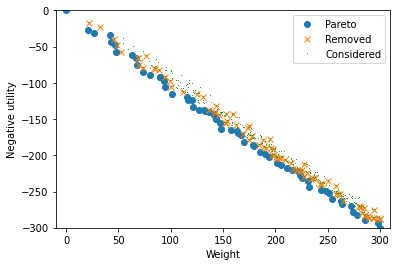

In [18]:
plt.axis([min(par_x)-x_buffer,
          max(par_x)+x_buffer,
          min(par_y)-y_buffer,
          max(par_y)+y_buffer])
plt.plot(par_x, par_y, 'o', label='Pareto')
plt.plot(rem_x, rem_y, 'x', label='Removed')
plt.plot(con_x, con_y, ',', label='Considered')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.legend()